<a href="https://colab.research.google.com/github/hrnnikolov/ML_models/blob/main/pytorch_classification_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
#import sklearn

In [100]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=33)

In [101]:
X[0:5]

array([[-0.92631372, -0.44504141],
       [ 0.34889196, -0.92585137],
       [-0.90612188, -0.02167732],
       [ 1.05520498,  0.01292639],
       [ 0.00257544, -1.00524639]])

In [102]:
import pandas as pd

circles = pd.DataFrame({'X1': X[:,0],
                        'X2': X[:,1],
                        'label': y})
circles

,X1,X2,label
0,-0.926314,-0.445041,0
1,0.348892,-0.925851,0
2,-0.906122,-0.021677,0
3,1.055205,0.012926,0
4,0.002575,-1.005246,0
...,...,...,...
995,-0.346955,0.764172,1
996,0.474477,0.642467,1
997,-0.778041,0.144401,1
998,0.241981,-0.984062,0


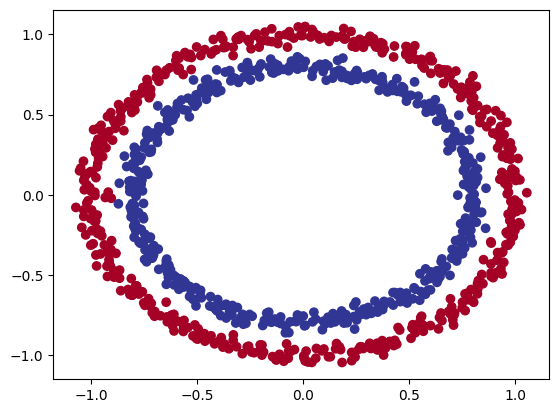

In [103]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [104]:
X.shape, y.shape

((1000, 2), (1000,))

In [105]:
import torch
torch.__version__

'2.1.0+cu121'

In [106]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [107]:
X[:5]

tensor([[-0.9263, -0.4450],
        [ 0.3489, -0.9259],
        [-0.9061, -0.0217],
        [ 1.0552,  0.0129],
        [ 0.0026, -1.0052]])

In [108]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=33, test_size=0.2)

In [109]:
X_train.shape

torch.Size([800, 2])

In [110]:
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [111]:
class CircleModel(nn.Module):
  def __init__(self) :
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x))

model_0 = CircleModel().to(device)
model_0


CircleModel(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [112]:
loss_fn = nn.BCEWithLogitsLoss() # this got sigmoid actv fn build in
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

In [113]:
# calc accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [114]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.2307],
        [0.2420],
        [0.2961],
        [0.3285],
        [0.2346]], device='cuda:0')

In [115]:
y_test[:5]

tensor([1., 1., 0., 0., 1.])

In [116]:
#logits to probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5574],
        [0.5602],
        [0.5735],
        [0.5814],
        [0.5584]], device='cuda:0')

In [117]:
y_preds = torch.round(y_pred_probs)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
torch.eq(y_preds.squeeze(), y_pred_labels.squeeze())

tensor([True, True, True, True, True], device='cuda:0')

In [118]:
y_preds.squeeze()

tensor([1., 1., 1., 1., 1.], device='cuda:0')

In [119]:
epochs = 500

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

  model_0.train()

  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()


  #testing
  model_0.eval()

  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

  if epoch % 10 ==0:
    print(f'Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test_Loss: {test_loss:.5f} | Test_Acc: {test_acc:.2f}%')


Epoch: 0 | Loss: 0.70139 | Acc: 50.38% | Test_Loss: 0.70769 | Test_Acc: 48.50%
Epoch: 10 | Loss: 0.70048 | Acc: 50.38% | Test_Loss: 0.70648 | Test_Acc: 48.50%
Epoch: 20 | Loss: 0.69967 | Acc: 50.38% | Test_Loss: 0.70540 | Test_Acc: 48.50%
Epoch: 30 | Loss: 0.69896 | Acc: 50.38% | Test_Loss: 0.70443 | Test_Acc: 48.50%
Epoch: 40 | Loss: 0.69832 | Acc: 50.38% | Test_Loss: 0.70355 | Test_Acc: 48.50%
Epoch: 50 | Loss: 0.69776 | Acc: 50.38% | Test_Loss: 0.70275 | Test_Acc: 48.50%
Epoch: 60 | Loss: 0.69726 | Acc: 50.38% | Test_Loss: 0.70204 | Test_Acc: 48.50%
Epoch: 70 | Loss: 0.69681 | Acc: 50.38% | Test_Loss: 0.70139 | Test_Acc: 48.50%
Epoch: 80 | Loss: 0.69642 | Acc: 50.38% | Test_Loss: 0.70080 | Test_Acc: 48.50%
Epoch: 90 | Loss: 0.69607 | Acc: 50.38% | Test_Loss: 0.70027 | Test_Acc: 48.50%
Epoch: 100 | Loss: 0.69576 | Acc: 50.38% | Test_Loss: 0.69979 | Test_Acc: 48.50%
Epoch: 110 | Loss: 0.69548 | Acc: 50.38% | Test_Loss: 0.69935 | Test_Acc: 48.50%
Epoch: 120 | Loss: 0.69523 | Acc: 50.38

In [120]:
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
  print('helper_functions.py already exists')
else:
  print('Downloading helper_functions.py')
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)

helper_functions.py already exists


In [121]:
from helper_functions import plot_predictions, plot_decision_boundary

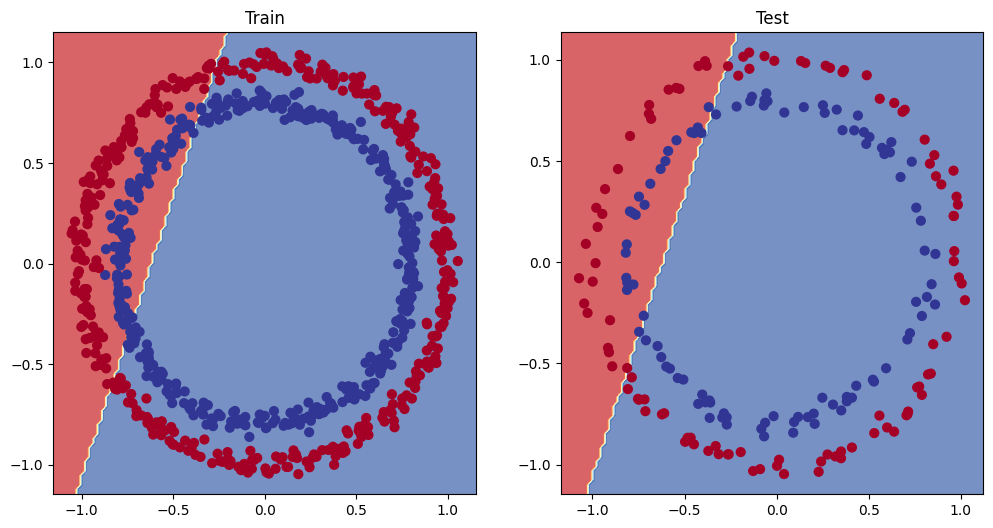

In [122]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2) # rows , cols , index
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

In [123]:
class CircleModelV1(nn.Module):
  def __init__(self) :
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [124]:
loss_fn = nn.BCEWithLogitsLoss() # this got sigmoid actv fn build in
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [125]:
epochs = 3000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

  model_1.train()

  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()


  #testing
  model_1.eval()

  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

  if epoch % 100 ==0:
    print(f'Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test_Loss: {test_loss:.5f} | Test_Acc: {test_acc:.2f}%')


Epoch: 0 | Loss: 0.69957 | Acc: 49.62% | Test_Loss: 0.69571 | Test_Acc: 51.50%
Epoch: 100 | Loss: 0.69301 | Acc: 46.62% | Test_Loss: 0.69294 | Test_Acc: 44.50%
Epoch: 200 | Loss: 0.69141 | Acc: 60.75% | Test_Loss: 0.69136 | Test_Acc: 62.50%
Epoch: 300 | Loss: 0.69022 | Acc: 60.88% | Test_Loss: 0.69030 | Test_Acc: 64.00%
Epoch: 400 | Loss: 0.68856 | Acc: 64.38% | Test_Loss: 0.68891 | Test_Acc: 62.50%
Epoch: 500 | Loss: 0.68616 | Acc: 64.75% | Test_Loss: 0.68688 | Test_Acc: 60.50%
Epoch: 600 | Loss: 0.68272 | Acc: 63.88% | Test_Loss: 0.68383 | Test_Acc: 62.00%
Epoch: 700 | Loss: 0.67747 | Acc: 66.00% | Test_Loss: 0.67894 | Test_Acc: 63.50%
Epoch: 800 | Loss: 0.66892 | Acc: 68.00% | Test_Loss: 0.67063 | Test_Acc: 65.50%
Epoch: 900 | Loss: 0.65394 | Acc: 73.38% | Test_Loss: 0.65568 | Test_Acc: 69.00%
Epoch: 1000 | Loss: 0.62657 | Acc: 83.62% | Test_Loss: 0.62788 | Test_Acc: 82.00%
Epoch: 1100 | Loss: 0.57449 | Acc: 91.38% | Test_Loss: 0.57443 | Test_Acc: 91.50%
Epoch: 1200 | Loss: 0.48147 

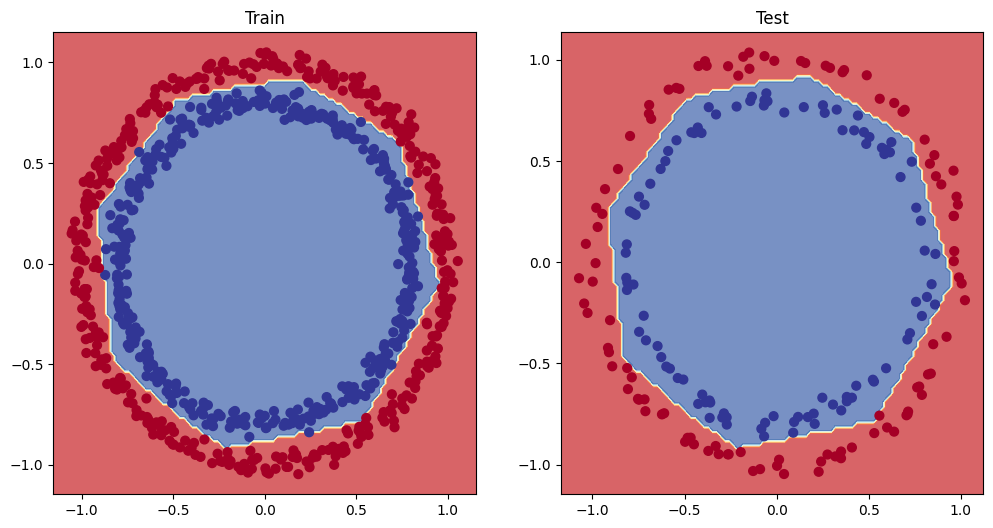

In [126]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2) # rows , cols , index
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)

In [127]:
#multiclass

In [128]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

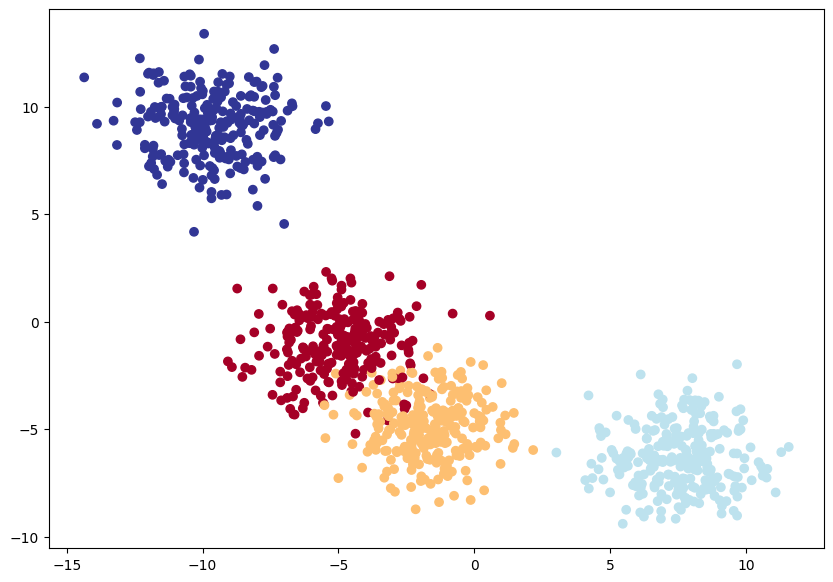

In [136]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 33

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)


X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

In [137]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [138]:
class BlobModel(nn.Module):
  def __init__(self, input_features: int, output_features: int, hidden_features=8) -> None:
    super().__init__()
    self.input_features = input_features
    self.output_features = output_features
    self.hidden_features = hidden_features
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features = self.input_features, out_features = self.hidden_features),
        nn.ReLU(),
        nn.Linear(in_features=self.hidden_features, out_features=self.hidden_features),
        nn.ReLU(),
        nn.Linear(in_features=self.hidden_features, out_features=self.output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model_3 = BlobModel(input_features = 2, output_features=4, hidden_features=8).to(device)
model_3

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [139]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

In [140]:
X_blob_train.shape

torch.Size([800, 2])

In [142]:
epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  #Train
  model_3.train()

  y_logits = model_3(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  #Test
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)

  if epoch % 10 == 0:
    print(f'Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test_Loss: {test_loss:.5f} | Test_Acc: {test_acc:.2f}%')

Epoch: 0 | Loss: 1.67677 | Acc: 50.50% | Test_Loss: 1.12498 | Test_Acc: 100.00%
Epoch: 10 | Loss: 0.55217 | Acc: 93.50% | Test_Loss: 0.51636 | Test_Acc: 100.00%
Epoch: 20 | Loss: 0.29183 | Acc: 97.00% | Test_Loss: 0.27906 | Test_Acc: 100.00%
Epoch: 30 | Loss: 0.17000 | Acc: 96.50% | Test_Loss: 0.17719 | Test_Acc: 100.00%
Epoch: 40 | Loss: 0.12265 | Acc: 96.50% | Test_Loss: 0.13734 | Test_Acc: 100.00%
Epoch: 50 | Loss: 0.10079 | Acc: 96.50% | Test_Loss: 0.11931 | Test_Acc: 100.00%
Epoch: 60 | Loss: 0.08904 | Acc: 96.50% | Test_Loss: 0.10977 | Test_Acc: 100.00%
Epoch: 70 | Loss: 0.08189 | Acc: 96.50% | Test_Loss: 0.10419 | Test_Acc: 100.00%
Epoch: 80 | Loss: 0.07721 | Acc: 96.50% | Test_Loss: 0.10067 | Test_Acc: 100.00%
Epoch: 90 | Loss: 0.07396 | Acc: 96.50% | Test_Loss: 0.09832 | Test_Acc: 100.00%


In [143]:
#evaluating

In [144]:
model_3.eval()
with torch.inference_mode():
  y_logits=model_3(X_blob_test)

y_logits[:10]

tensor([[-6.4337,  2.8608,  8.0453, -5.1020],
        [-8.3024,  3.6937, 10.3101, -6.5817],
        [-7.3908,  2.6853,  9.1184, -5.2855],
        [ 3.6277, -3.1374, -2.4445,  6.7932],
        [ 3.4119, -3.5088, -2.3632,  7.6239],
        [ 3.3803,  2.8013, -2.3505, -2.9533],
        [-7.4541,  2.9185,  9.2247, -5.5312],
        [ 6.3383,  2.2640, -4.1783, -3.0891],
        [ 3.1360,  1.4283, -2.0237, -1.7478],
        [ 2.5907, -3.2540, -1.8367,  7.1677]], device='cuda:0')

In [147]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[5.1214e-07, 5.5713e-03, 9.9443e-01, 1.9398e-06],
        [8.2429e-09, 1.3363e-03, 9.9866e-01, 4.6064e-08],
        [6.7518e-08, 1.6048e-03, 9.9839e-01, 5.5430e-07],
        [4.0479e-02, 4.6688e-05, 9.3349e-05, 9.5938e-01],
        [1.4600e-02, 1.4413e-05, 4.5314e-05, 9.8534e-01],
        [6.3877e-01, 3.5802e-01, 2.0725e-03, 1.1343e-03],
        [5.6977e-08, 1.8216e-03, 9.9818e-01, 3.8977e-07],
        [9.8318e-01, 1.6717e-02, 2.6628e-05, 7.9132e-05],
        [8.3710e-01, 1.5175e-01, 4.8077e-03, 6.3355e-03],
        [1.0180e-02, 2.9472e-05, 1.2160e-04, 9.8967e-01]], device='cuda:0')

In [148]:
y_preds = y_pred_probs.argmax(dim=1)
y_preds

tensor([2, 2, 2, 3, 3, 0, 2, 0, 0, 3, 1, 3, 1, 1, 3, 1, 1, 2, 3, 0, 2, 1, 2, 3,
        0, 0, 1, 3, 2, 1, 1, 1, 3, 2, 3, 1, 0, 2, 0, 3, 1, 3, 2, 3, 1, 3, 3, 3,
        0, 0, 0, 3, 1, 3, 1, 3, 2, 3, 1, 3, 2, 2, 1, 0, 3, 3, 1, 3, 0, 0, 0, 0,
        0, 0, 3, 2, 3, 1, 2, 1, 0, 3, 0, 3, 3, 2, 3, 1, 3, 3, 2, 2, 0, 0, 0, 0,
        1, 1, 0, 2, 2, 1, 3, 3, 0, 0, 2, 1, 2, 1, 0, 0, 2, 1, 1, 3, 3, 3, 2, 0,
        2, 3, 2, 0, 0, 0, 0, 3, 2, 1, 0, 1, 1, 0, 3, 1, 1, 1, 3, 1, 0, 0, 3, 3,
        1, 3, 2, 3, 1, 1, 2, 0, 2, 0, 2, 2, 0, 3, 1, 2, 0, 2, 0, 3, 3, 0, 2, 1,
        0, 3, 3, 0, 3, 3, 0, 1, 2, 1, 0, 0, 1, 1, 1, 1, 3, 3, 3, 0, 3, 1, 1, 2,
        3, 2, 1, 2, 3, 3, 3, 1], device='cuda:0')

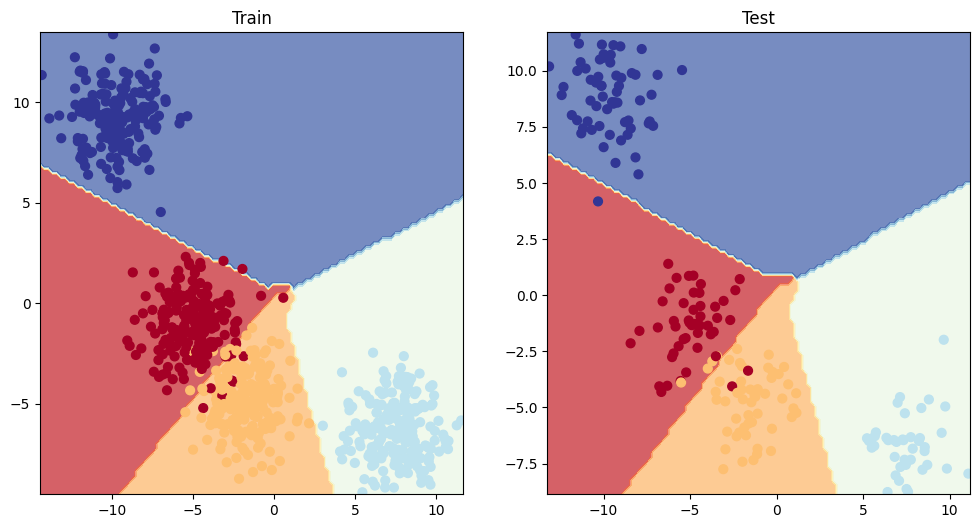

In [158]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_3, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_3, X_blob_test, y_blob_test)



In [153]:
X_blob_train.shape, y_blob_train.shape

(torch.Size([800, 2]), torch.Size([800]))